# Unicornn


In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import librosa
import collections

from tqdm import tqdm

## Params
Die hier auf gelisteten Parameter ermöglichen die wichtigsten Einstellungen.

In [2]:
# Generel Params
durationOfAudioSample = 1 # Length of AudioSamples for Training
showDataBalance = True # Shows Data Balance in the complete and the splitted Datasets. (time intensive)

batchSize=64            # Batch size for Training
epochs=1                # Number of Epochs for Training

# Checks if gpu is available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Utils

Im Folgenden werden zunächst einige Hilfsfunktionen erstellt.

### Wave2Image

In [3]:
def wave2image(file):

    samples, sample_rate = librosa.core.load(file,sr=16000)

    # correct length of audiosample to fix length
    fixed_sample_length = int(durationOfAudioSample * sample_rate)
    if fixed_sample_length < len(samples):      #truncate
        samples = samples[:fixed_sample_length]
    elif fixed_sample_length > len(samples):    # add silence
        samples = np.pad(samples, (0, fixed_sample_length - len(samples)), "constant")

    # Create MelSpectrum
    s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=32)
    mel = librosa.power_to_db(s, ref=np.max)
    return mel

### Show Image

Die Funktion `show(image,title = None)` ermöglicht das Plotten von Bildern.
Das Argument `title` ist optional und kann z.B. für das entsprechende Label verwendet werden.

In [4]:
def show(_image,_title = None):
    plt.figure(figsize=(15, 5))
    plt.imshow(_image[0])
    if _title is not None:
        plt.title(_title)
    plt.show()

### Count Labels in Dataset

Die Funktion `dataBalance` zählt wie oft ein Label im Datensatz vorkommt und gibt die Werte
als Liste zurück. Der Index in der Liste entspricht dabei dem Label (erster Eintrag
entspricht der absoluten Häufigkeit von Label 0 im Datensatz, der darauf folgende Wert Label 1 usw.).

In [5]:
def dataBalance(_dataset):

    _y = [y for _,y,_ in _dataset]
    _counter = collections.Counter(_y)

    _sizes = []

    for i in range(0, len(_counter)):
        _sizes.append(_counter[i])

    return _sizes

## Dataset

Die Klasse `CommandDataset` representiert den kompletten Datensatz.

In der `__init__(self)` Funktion werden alle Pfade zu Daten
vereint und die entsprechenden Labels erstellt.

Die Funktion `__len__(self)` gibt die Anzahl der Einträge im Datensatz an.

Der Zugriff auf Datensatzeinträge erfolgt ähnlich wie bei Listen
oder Arrays (`dataset[idx]` gibt den `idx`-ten Eintrag zurück).
Dabei wird die Klasse `__getItem__(self,idx)` aufgerufen, in welcher der
`idx`-te Eintrag erstellt wird. Die Rückgabe besteht aus dem Bild des MelSpektrograms, dem Label,
sowie dem Pfad zur Wave-Datei.

Einträge im Datensatz: 57348
Random Element: Dataset/data-speech_commands_v0.02/nine/37fc5d97_nohash_0.wav


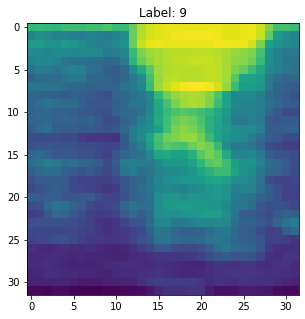

In [6]:
class CommandDataset(torch.utils.data.Dataset):

    def __init__(self):
        paths = ["Dataset/data-speech_commands_v0.02/zero/",
                 "Dataset/data-speech_commands_v0.02/one/",
                 "Dataset/data-speech_commands_v0.02/two/",
                 "Dataset/data-speech_commands_v0.02/three/",
                 "Dataset/data-speech_commands_v0.02/four/",
                 "Dataset/data-speech_commands_v0.02/five/",
                 "Dataset/data-speech_commands_v0.02/six/",
                 "Dataset/data-speech_commands_v0.02/seven/",
                 "Dataset/data-speech_commands_v0.02/eight/",
                 "Dataset/data-speech_commands_v0.02/nine/",

                 "Dataset/data-speech_commands_v0.02/forward/",
                 "Dataset/data-speech_commands_v0.02/backward/",
                 "Dataset/data-speech_commands_v0.02/left/",
                 "Dataset/data-speech_commands_v0.02/right/",
                 "Dataset/data-speech_commands_v0.02/up/",
                 "Dataset/data-speech_commands_v0.02/down/",
                 ]
        self.classes = len(paths)

        self.datasetItems = []
        self.exampleIDs = []
        _id = -1
        for _label in range(0,len(paths)):
            for filename in os.listdir(paths[_label]):
                self.datasetItems.append((os.path.join(paths[_label],filename),_label))
                _id += 1
            self.exampleIDs.append(_id)

    def __len__(self):
        return len(self.datasetItems)

    def __getitem__(self, idx):
        _image = wave2image(self.datasetItems[idx][0])

        #scale to Range[0;1]
        _min = np.min(_image)
        _image -= _min
        _max = np.max(_image)
        _image /=_max

        return torch.Tensor(_image).unsqueeze(0), self.datasetItems[idx][1], self.datasetItems[idx][0]

commandDataset = CommandDataset()
print("Einträge im Datensatz:", len(commandDataset))

random_idx = random.randint(0, len(commandDataset)-1)
image, label, path = commandDataset[random_idx]
print("Random Element:", path)
show(image,"Label: " + str(label))

Class Examples:


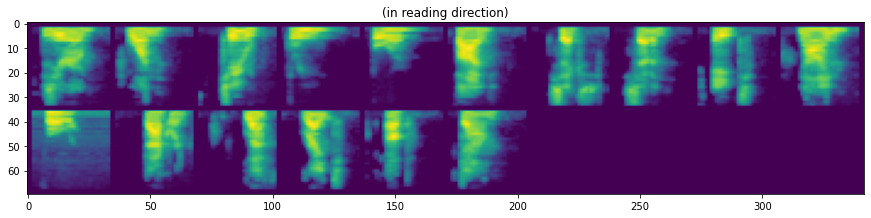

In [7]:
print("Class Examples:")
grid = [commandDataset[i][0] for i in commandDataset.exampleIDs]

grid = torchvision.utils.make_grid(grid, nrow=10, padding=2)
show(grid.numpy(), "(in reading direction)")

### Splitting

Um den Trainingsprozess später evaluieren zu können wird der Datasatz in einen
Trainings- und einen Evaluierungsdatensatz aufgeteilt. Das Verhältnis zwischen den
beiden Datensätzen ist 80:20.

In [8]:
len_ds = len(commandDataset)
len_train = int(0.8*len_ds)
len_val = len_ds - len_train

train_ds, val_ds = torch.utils.data.random_split(commandDataset,[len_train,len_val])

print("Trainingsdaten:", len(train_ds))
print("Evaluierungsdaten:", len(val_ds))

Trainingsdaten: 45878
Evaluierungsdaten: 11470


### Balance in Datasets

Im Folgenden wird die Verteilung der Einträge nach Label in den verschiedenen Datensätzen
visuell verglichen. Da der Prozess relativ rechenaufwendig ist, kann dieser Abschnitt
übersprungen werden indem die Variable `showDataBalance` auf `False` gesetzt wird.

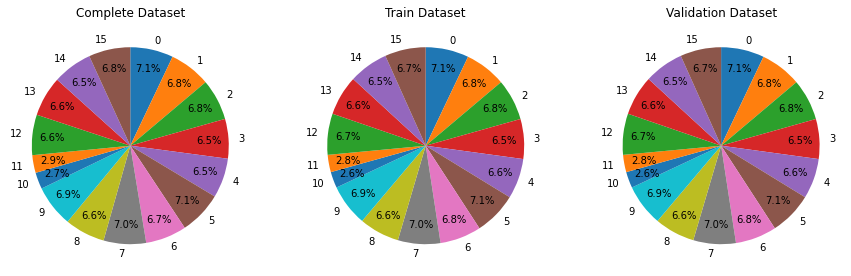

In [9]:
if showDataBalance == True:

    complete_balance = dataBalance(commandDataset)
    train_balance = dataBalance(train_ds)
    val_balance = dataBalance(val_ds)

    pie_labels = np.arange(commandDataset.classes)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.pie(complete_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
    plt.title("Complete Dataset")
    plt.subplot(132)
    plt.pie(train_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
    plt.title("Train Dataset")
    plt.subplot(133)
    plt.pie(train_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
    plt.title("Validation Dataset")
    plt.show()
else:
    print("Inorder to plot data balance set showDateBalance=True.")

### DataLoader

`DataLoader` bilden aus den Einträgen in einem Datensatz Batches. Durch `shuffle=True` werden
die Batches aus zufälligen Datensatzeinträgen zusammengestellt. Die Größe der Batches wird durch die Variable
`batchSize` angegeben.

In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batchSize, shuffle=True)

print("Batches im Trainingsdatensatz:",len(train_dl))
print("Batches im Evaluierungsdatensatz:",len(val_dl))

Batches im Trainingsdatensatz: 717
Batches im Evaluierungsdatensatz: 180


## Model


## Training

In [11]:
for e in range(0,epochs):

    for x, y_real, _ in tqdm(train_dl):

        print("Image Batch:", x.shape)
        print("Label Batch:", y_real.shape)
        break

  0%|          | 0/717 [00:00<?, ?it/s]


Image Batch: torch.Size([64, 1, 32, 32])
Label Batch: torch.Size([64])
